# 比特币钱包技术细节  - HD钱包介绍
## 钱包分类
绝大多数钱包应用在创建钱包时千叮咛万嘱咐让你做好备份的助记词是怎么回事儿？为什么这些钱包自称是HD钱包？为什么说泄露了助记词就丢失了所有的币？为什么用单个助记词可以产生、控制很多个账户？助记词究竟是怎么产生私钥的？安全性有没有保障？破解的难度究竟有多大？
这些问题都会在本文中一一阐述。
### 随机钱包
比特币早期的钱包客户端 Satoshi Client 里面会自动随机生成 100 个私钥、公钥对，这些私钥之间完全没有关联，这种钱包也叫做随机钱包或者非确定性钱包（Non-Deterministic Wallet），钱包的备份和恢复必须针对每个私钥进行。
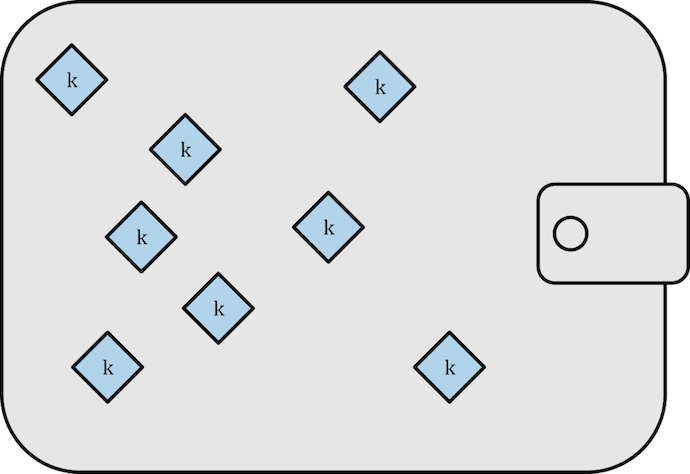

### 线性确定性钱包
如果能随机产生一个种子，然后根据这个种子去生成一系列的私钥、公钥对，这样钱包的备份就会容易很多，因为只需要备份随机的种子就行了，这种根据随机种子按确定规则生成一系列钱包的方式就叫做种子钱包（Seeded Wallet）或确定性钱包（Deterministic Wallet），种子钱包在生成多个私钥时会用到序号作为参数，所以这种钱包也叫线性确定性钱包（Sequential Deterministic Wallet）。
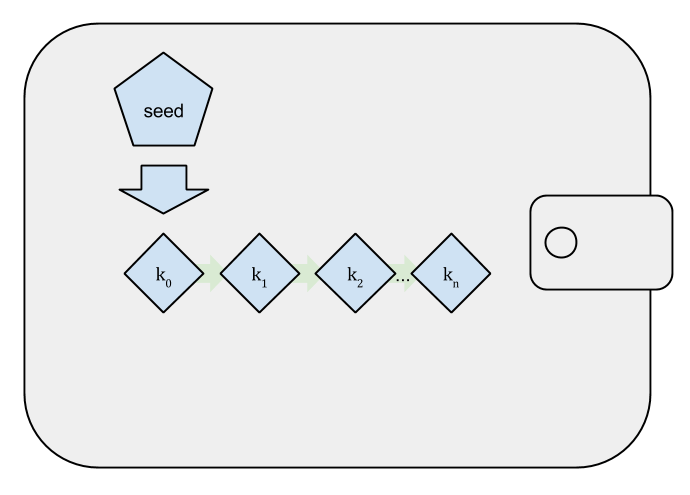

### 分层确定性钱包
种子钱包解决了备份的问题，但是还是不完美，没有办法把钱包的一部分共享出去给别人管理，但同时自己保有知情权、控制权。社区的智慧是无穷的，分层确定性钱包应运而生。因为生成的钱包结构是有层次的，所以就被叫做 Hierarchical Deterministic Wallet：
- 树状的钱包结构可以让钱包的组织方式更加灵活，或者赋予其现实世界的意义，比如可以用单个 HD 钱包来管理组织的所有资产；
- 每个节点都会有私钥、公钥，也可以派生出更多的子节点；
- 树状结构中的某个分支及其子树可以根据实际需要共享出去；
- 备份和恢复只需要关心主节点；
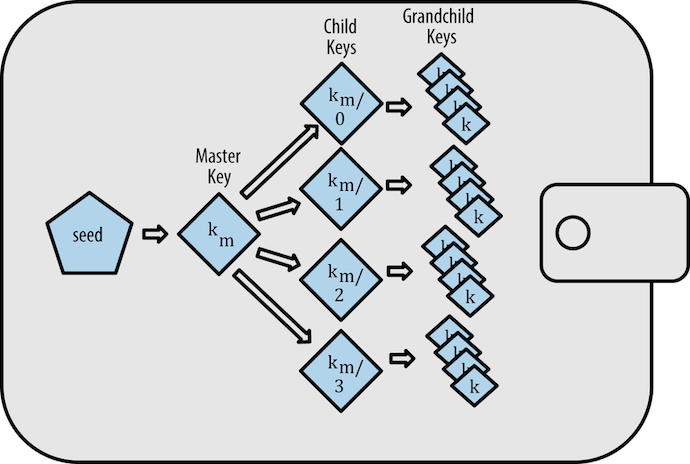

## BIP
BIP是协议，是Bitcoin Improvement Proposals的缩写，意思是Bitcoin的改进建议，用于提出 Bitcoin 的新功能或改进措施。BIP协议衍生了很多的版本，详情请关注：https://github.com/bitcoin/bips
### BIP32
BIP32是 HD钱包的核心提案，通过种子来生成主私钥，然后派生海量的子私钥和地址，种子是一串很长的随机数。

### BIP39
由于种子是一串很长的随机数，不利于记录，所以我们用算法将种子转化为一串12 ~ 24个的单词，方便保存记录，这就是BIP39，它扩展了 HD钱包种子的生成算法。

### BIP44
BIP44 是在 BIP32 和 BIP43 的基础上增加多币种，提出的层次结构非常全面，它允许处理多个币种，多个帐户，每个帐户有数百万个地址。
在BIP32路径中定义以下5个级别：
`m/purpse'/coin_type'/account'/change/address_index`

- purpose：在BIP43之后建议将常数设置为44'。表示根据BIP44规范使用该节点的子树。
- Coin_type：币种，代表一个主节点（种子）可用于无限数量的独立加密币，如比特币，Litecoin或Namecoin。此级别为每个加密币创建一个单独的子树，避免重用已经在其它链上存在的地址。开发人员可以为他们的项目注册未使用的号码。
- Account：账户，此级别为了设置独立的用户身份可以将所有币种放在一个的帐户中，从0开始按顺序递增。
- Change：常量0用于外部链，常量1用于内部链，外部链用于钱包在外部用于接收和付款。内部链用于在钱包外部不可见的地址，如返回交易变更。
- Address_index：地址索引，按顺序递增的方式从索引0开始编号。

BIP44的规则使得 HD钱包非常强大，用户只需要保存一个种子，就能控制所有币种，所有账户的钱包，因此由BIP39 生成的助记词非常重要，所以一定安全妥善保管，那么会不会被破解呢？如果一个 HD 钱包助记词是 12 个单词，一共有 2048 个单词可能性，那么随机的生成的助记词所有可能性大概是5e+39，因此几乎不可能被破解。

## 助记词的生成过程
BIP39是助记词标准的实现，助记词是一个随机数的字序列，用来作为种子产生一个确定性的钱包。单词序列足以重新创建种子，然后再创建钱包和所有派生的密钥。一个实现带有助记词的确定性钱包应用程序在首次创建钱包时将向用户显示12到24个单词的序列。该单词序列是钱包备份，可用于恢复和重新创建相同或任何兼容的钱包应用程序中的所有密钥。记忆单词使用户更容易备份钱包，因为与随机数字序列相比，它们易于阅读和正确地转录。所有的助记词在这里可以查看：[助记词词库](https://github.com/bitcoin/bips/blob/master/bip-0039/bip-0039-wordlists.md)。
使用BIP39中定义的标准化过程，钱包自动生成助记词。钱包从一个熵源开始，添加一个校验和，然后将熵映射到一个单词列表，具体步骤如下:
1. 创建128到256位的随机序列（熵）。
2. 通过获取SHA256哈希的第一（熵长度/ 32）位来创建随机序列的校验和。
3. 将校验和添加到随机序列的末尾。
4. 将序列分成11位的部分。
5. 将每个11位值映射到来自2048个单词的预定义字典中的单词。
6. 助记词是单词序列。

生成助记词的步骤如下图：


下表描述了初始熵长度（ENT），校验和长度（CS）和单词中生成的助记词（MS）的长度之间的关系。

| 熵（bits） | Checksum（bits） | 熵+Checksum（bits） | 助记词长度（words） |
| :--------- | :--------------- | :------------------ | :------------------ |
| 128        | 4                | 132                 | 12                  |
| 160        | 5                | 165                 | 15                  |
| 192        | 6                | 198                 | 18                  |
| 224        | 7                | 231                 | 21                  |
| 256        | 8                | 264                 | 24                  |
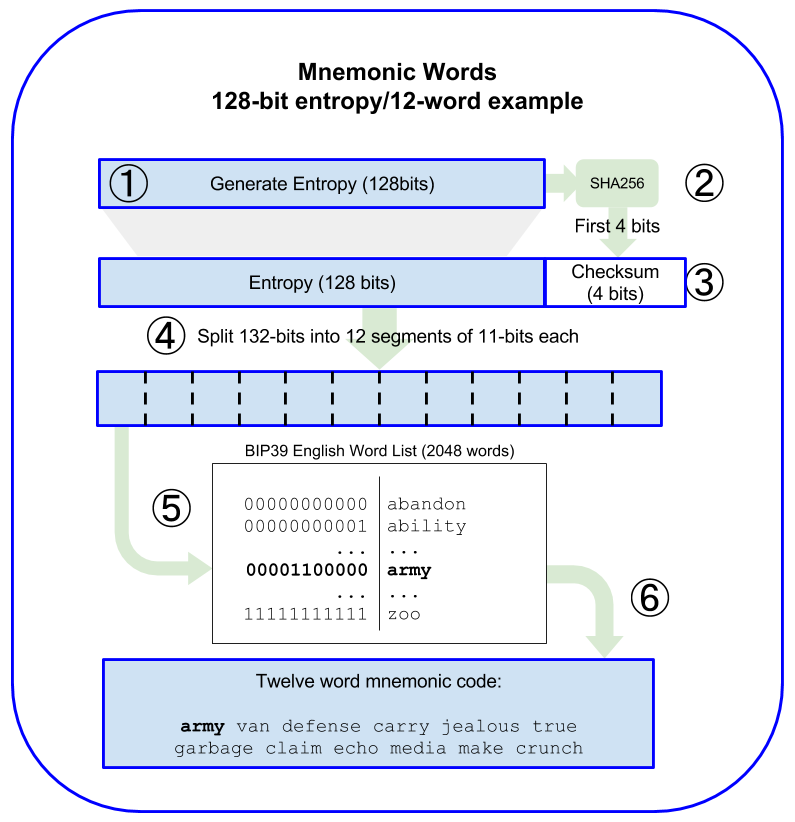

In [1]:
import hashlib
import codecs

# 为了演示的确定性，通过一个单词去生成熵，实际生成熵应该是完全随机的
word = 'Stefans'
entropy = hashlib.md5(bytes(word,'utf-8'))
entropy_160 = hashlib.sha1(bytes(word,'utf-8'))
entropy_256 = hashlib.sha256(bytes(word,'utf-8'))
print('生成熵(128位):',entropy.hexdigest())
print('生成熵(160位):',entropy_160.hexdigest())
print('生成熵(256位):',entropy_256.hexdigest())

生成熵(128位): 985d2e934cc234bed4e418552be7c71e
生成熵(160位): 18a4ca6e1cdaaa9429918fd7586a77c8e5549e36
生成熵(256位): 4cd5b6a41c74709776a78a50074081ea2648723a99edfac6241f8492a7305095


In [2]:
# 得到checksum
checksum = hashlib.sha256(entropy.digest()).hexdigest()
checksum_160 = hashlib.sha256(entropy_160.digest()).hexdigest()
checksum = bin(int(checksum, 16))[2:].zfill(256)[: len(entropy.hexdigest()) // 8 ]
checksum_160 = bin(int(checksum_160, 16))[2:].zfill(256)[: len(entropy_160.hexdigest()) // 8 ]
print('Sha256(128位熵):',hashlib.sha256(entropy.digest()).hexdigest())
print('Sha256(160位熵):',hashlib.sha256(entropy_160.digest()).hexdigest())
print('通过熵获取Checksum(128位获取4比特):',checksum)
print('通过熵获取Checksum(160位获取5比特):',checksum_160)

Sha256(128位熵): 4678863f7c9b6402b52ae4a1c305e7ab3836ed13ec7fd95defa3481a9de598a8
Sha256(160位熵): 6d5aca92c6f32b71751bb11bc7ff63facf788b93579d3e14297d7fe029bd21d2
通过熵获取Checksum(128位获取4比特): 0100
通过熵获取Checksum(160位获取5比特): 01101


In [3]:
import re
# 把字符串按照固定位数分割
def split_bin(text,length):
    b=re.findall('.{'+str(length)+'}', text) 
    c=' '.join(b)
    return c

In [4]:
import binascii
from binascii import hexlify, unhexlify
# 通过熵+Checksum获得Mnemonic
entropy_checksum_bin = bin(int(hexlify(entropy.digest()),16))[2:].zfill(len(entropy.hexdigest()) * 4) + checksum
entropy_checksum_bin = split_bin(entropy_checksum_bin,11)

entropy_checksum_bin_160 = bin(int(hexlify(entropy_160.digest()),16))[2:].zfill(len(entropy_160.hexdigest()) * 4) + checksum_160
entropy_checksum_bin_160 = split_bin(entropy_checksum_bin_160,11)
print('***************************128位熵 - 12个助记词 - English**************************')
mnemo = Mnemonic("english")
my_mneonic = mnemo.to_mnemonic(entropy.digest())
print('按11位分割的二进制:',entropy_checksum_bin)
print('生成助记词:',my_mneonic)

print('\n***************************128位熵 - 12个助记词 - chinese_simplified**************************')
mnemo_chinese_simplified = Mnemonic("chinese_simplified")
my_mneonic_chinese_simplified = mnemo_chinese_simplified.to_mnemonic(entropy.digest())
print('生成助记词:',my_mneonic_chinese_simplified)

print('\n***************************160位熵 - 15个助记词 - English**************************')
my_mneonic_160 = mnemo.to_mnemonic(entropy_160.digest())
print('按11位分割的二进制:',(entropy_checksum_bin_160))
print('生成助记词:',my_mneonic_160)

***************************128位熵 - 12个助记词 - English**************************
按11位分割的二进制: 10011000010 11101001011 10100100110 10011001100 00100011010 01011111011 01010011100 10000011000 01010101001 01011111001 11110001110 00111100100
生成助记词: obscure truly pill office cash garage fatal loan festival game vault develop

***************************128位熵 - 12个助记词 - chinese_simplified**************************
生成助记词: 岸 脆 牧 惯 世 游 独 荷 良 吧 汪 满

***************************160位熵 - 15个助记词 - English**************************
按11位分割的二进制: 00011000101 00100110010 10011011100 00111001101 10101010101 01001010000 10100110010 00110001111 11010111010 11000011010 10011101111 10010001110 01010101010 01001111000 11011001101
生成助记词: board chaos oppose defy primary energy play cradle struggle select over mushroom fetch excuse super


**小结**
1. 助记词是由熵+校验和的二进制组合每11位进行分割，并找到每一组二进制对应的单词序列组合而成
2. 你也可以自行找到喜欢的单词组合作为助记词，但是不建议这样做，因为不安全，自由组合助记词时，需要保证最后一个单词满足校验和要求

## 从助记词到种子
用户可以决定用密码来保护他们的助记符。如果不存在密码短语，则使用空字符串“”。

助记词代表长度为128到256位的熵。然后使用熵通过使用密钥扩展函数PBKDF2来导出更长（512位）的种子。然后，所产生的种子用于构建确定性钱包并获得其密钥。

密钥扩展功能有两个参数：助记词和盐（salt）。密钥扩展功能中的盐的目的是使得难以构建能够进行暴力攻击的查找表。在BIP-39标准中，salt具有另一个目的 - 它允许引入密码短语作为保护种子的额外安全因子。

1. PBKDF2密钥扩展功能的第一个参数是从步骤6产生的助记词。
2. PBKDF2密钥扩展功能的第二个参数是salt。salt由字符串常量“mnemonic”和可选的用户提供的密码短语字符串组成。
3. PBKDF2使用2048轮HMAC-SHA512哈希算法来扩展助记词和salt参数，产生512位值作为其最终输出。那个512位的值就是种子。

使用助记词来生成种子的步骤如下图：


需要注意的是，不同语言下生成的助记词，最后的种子是不一样的。下面演示一下助记词生成种子的实例（参考网站：https://iancoleman.io/bip39/#chinese_simplified ）：
- 12个长度的助记词，无密码生成种子
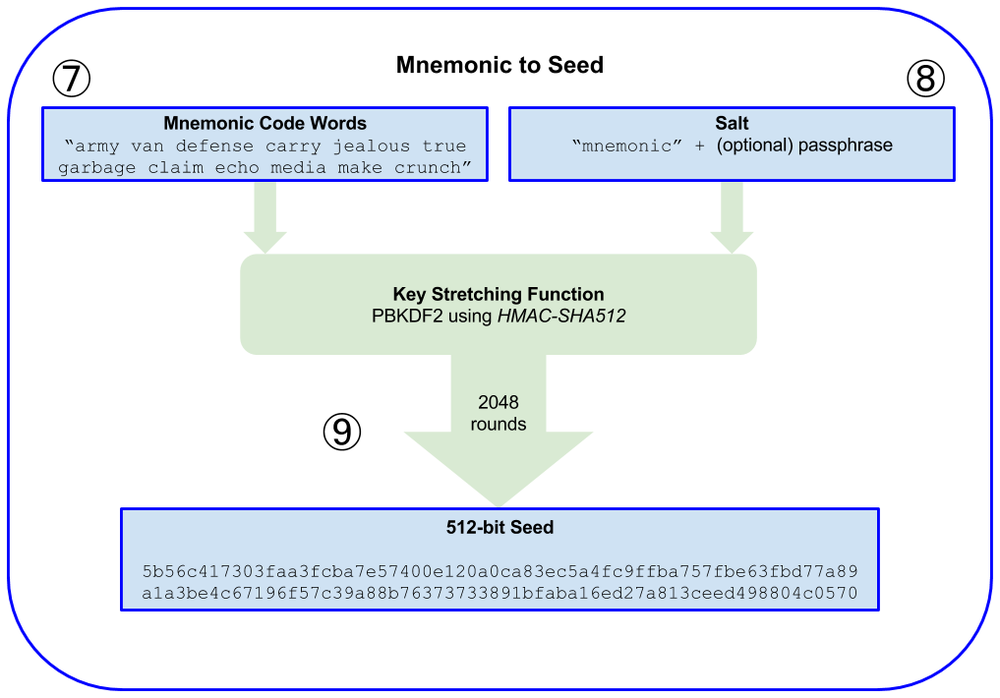

In [5]:
seed_npp12 = mnemo.to_seed(my_mneonic,"")
print("无密码生成的种子:",seed_npp12.hex())

无密码生成的种子: feb3dc3bee842bdabc212b809a08dff08f34511279baf2b29e24c1e7c58a0be9812065953115e3ee4b936ca3841c83d0cb961c07395dd459d2e1626b840bf021


- 12个长度的助记词，有密码生成种子

In [6]:
seed_pp12 = mnemo.to_seed(my_mneonic,"123456")
print("有密码生成的种子:",seed_pp12.hex())

有密码生成的种子: 2b35dc49a27ab1d1c98437ed257e775a5a42d0aaf5b48759b07a0b6d57b68804d598086cd76a57a94feb051d1adbfc224fe7626967d21e25f67d275978e5a612


## 种子生成主密钥

In [7]:
master_key = mnemo.to_hd_master_key(seed_npp12)
print("获得分层确定性钱包主密钥：",master_key)

获得分层确定性钱包主密钥： xprv9s21ZrQH143K3DWGh7WmNUs1Q9VFJEk3bDXzUU8RDyGDDbYBhSuVXpqV2AAajvVQwhg61RUQbZvANXgmYYLfusQXLJHfZuD6s8ybyYMAu8J


验证网站：https://iancoleman.io/bip39/
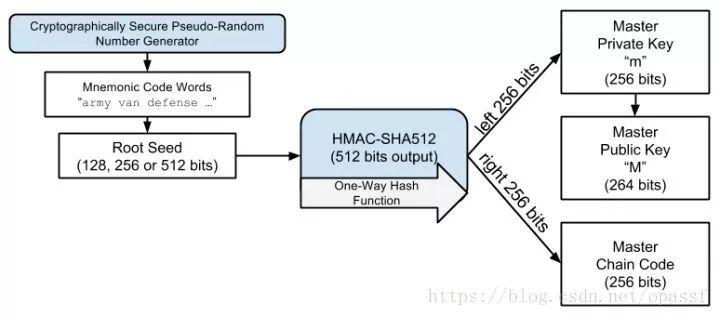

## 父密钥推导子密钥
我们先来看 BIP32，其中定义了如下两个内容：
- 根据父节点公（私）钥匙派生子节点公（私）钥的算法；
- 将派生出来的钥匙对组织成树状结构的方法。

在BIP32中根据父节点去派生子节点的方法被称作 Child Key Derivation Function，简称为 CKD，CKD 根据如下 3 个参数去生成子节点：
- 父节点私钥或者公钥（Parent Private/Public Key），公钥必须为非压缩公钥
- 父节点链码（Parent Chain Code）
- 子节点序号（Child Index）

为了保证生成过程不可逆，CKD 会用到单向哈希函数HMAC-SHA512，整个HD Wallet树里面的任何节点都可以有私钥、公钥，都具有如下的性质：
- 各节点的私钥和随机生成的私钥并没有明显的区分
- 节点私钥可以用来推导出节点公钥，进而推导出地址
- 节点私钥可以用来签名交易
- 至于节点之间的父子、兄弟关系在HD钱包之外完全是无感的（子密钥不能向上推导出父密钥、同时也不能水平推导出同一级的密钥）

### 关于扩展密钥
因为这个密钥衍生函数是单向的，所有**子密钥**都是不能够被用来推导出它们的**父密钥**的，也不能推导出同层级的**兄弟密钥**的，只有**父密钥**和**父链码**可以推导出所有的**子密钥**和**子链码**，后续也就可以生成相应的**子公钥**以及**地址**，并且用于对交易进行签名。

将**密钥（Key）**和**链码（Chain Code）**结合起来称为**扩展密钥（extended key）**，可以通过扩展密钥来生成自其而下的所有分支。

扩展密钥中提供的密钥可以为**私钥**或者**公钥**，和**链码**结合起来分别称为**扩展私钥（extended private key）**和**扩展公钥（extended public key）**，并且分别记为 (k, c) 和 (K, c)，其中公钥 K = point(k)。

我们可以从**扩展私钥**推导出**扩展公钥**，而反之则不可以，因此对于某些交易场景（如电商），可以为每笔交易生成一个新的公钥和地址来收款，而扩展私钥可以被存储在纸质钱包或者硬件钱包中，用于安全的离线签署交易。可以看到**扩展公钥**的安全性相对高一些，下图为通过扩展父公钥来衍生子私钥进而生成子公钥的传递机制：


**注： 扩展密钥 也通过 Base58Check 进行编码，扩展私钥 和 扩展公钥 的编码分别以 xprv 和 xpub 作为前缀。**

### 如何生成子密钥
> 有三种方式可以生成子密钥。
1. 子私钥派生（Extending a parent private key to create a child private key）
2. 子公钥派生
3. 强化子密钥派生

#### 子私钥派生
根据父节点私钥（Parent Private Key）生成子节点私钥（Child Private Key）的流程如下图：

1. 根据父节点私钥和椭圆曲线乘法推导出父节点公钥（Parent Public Key）；
2. 把父节点公钥、父节点链码、子节点序号作为参数求 HMAC-SHA512 得到512位输出；
3. 把步骤 2 的输出拆分为两个等长的 256 位串，分别标记为 L、R；
4. 把步骤 3 的输出 L 和父节点私钥做运算得到子节点私钥（Child Private Key）；
5. 把步骤 3 的输出 R 当做子节点链码（Child Chain Code）；

子节点私钥、子节点链码可以作为输入传给 CKD，就可以生成孙节点，以及任意深度的节点。子私钥生成函数在 BIP32 中被标记为：$$CKDpriv((k_{par},c_{par}),i) -> (k_i,c_i)$$
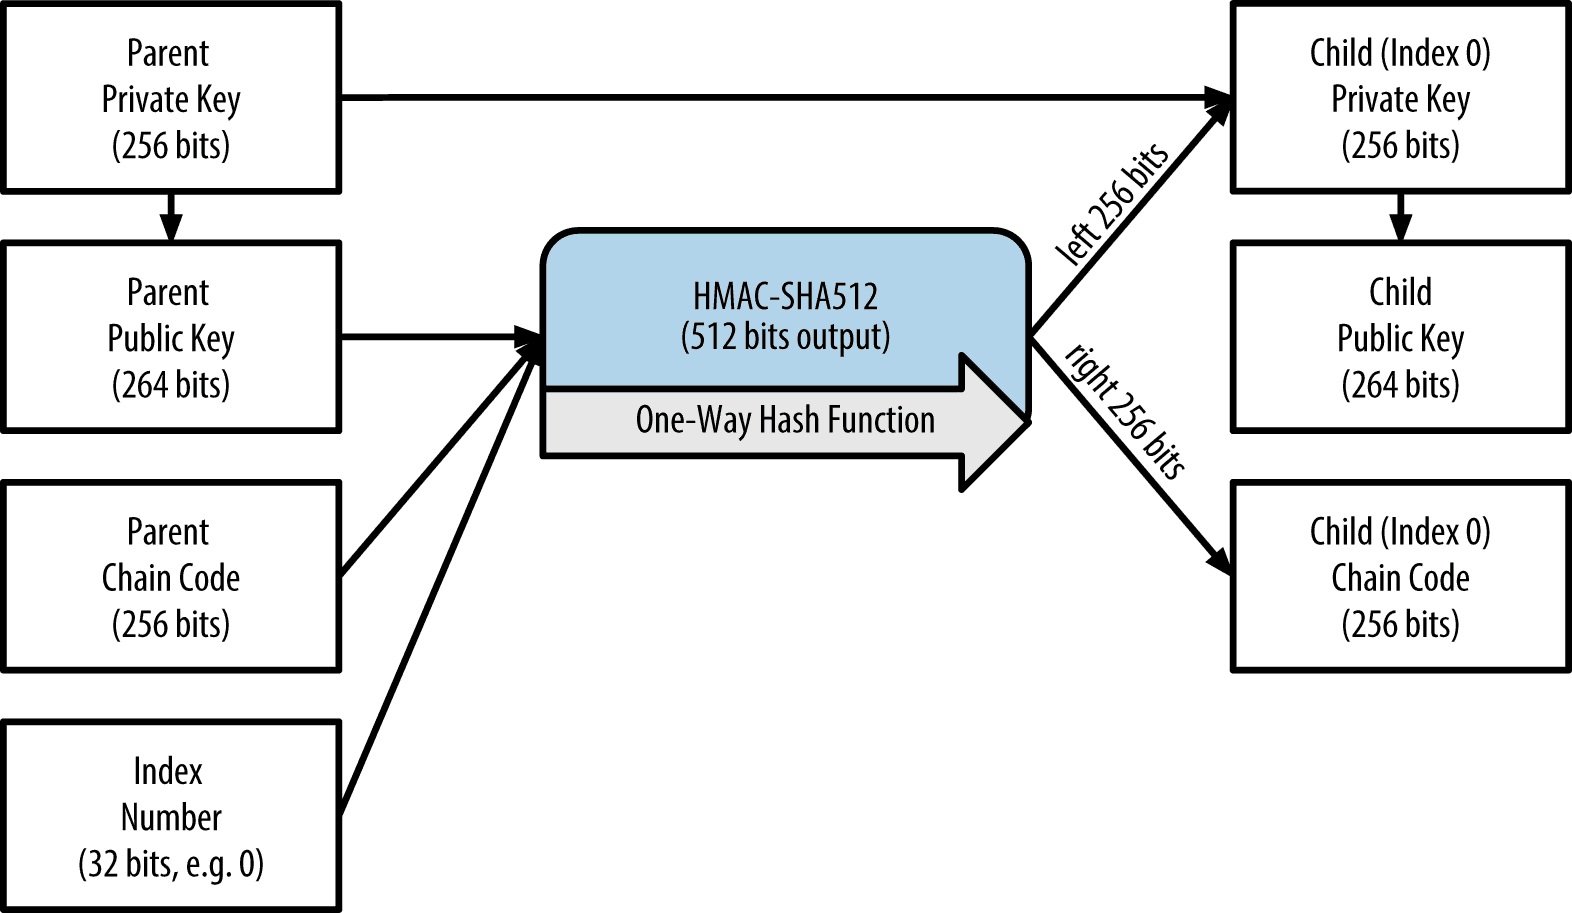

我们先来看看主密钥、扩展私钥、扩展公钥、以及对应的私钥是什么：

In [19]:
import ecdsa
import base58
def ECC_compressed(pk):
    secret = unhexlify(pk)
    order = ecdsa.SigningKey.from_string(secret, curve=ecdsa.SECP256k1).curve.generator.order()
    p = ecdsa.SigningKey.from_string(secret, curve=ecdsa.SECP256k1).verifying_key.pubkey.point
    x_str = ecdsa.util.number_to_string(p.x(), order)
    y_str = ecdsa.util.number_to_string(p.y(), order)
    uncompressed = hexlify(bytes(chr(4), 'ascii') + x_str + y_str).decode('ascii')
    compressed = hexlify(bytes(chr(2 + (p.y() & 1)), 'ascii') + x_str).decode('ascii')
    return compressed

address_version_prefix = '00'
def ripemd160(s):
    ripemd160 = hashlib.new('ripemd160')
    ripemd160.update(unhexlify(s))
    return ripemd160.digest()

def get_address(public_key):
    pkbin = unhexlify(public_key)
    addressbin = ripemd160(hexlify(hashlib.sha256(pkbin).digest()))
    addressbin = hexlify(addressbin).decode('ascii')
    addressbin = codecs.decode(address_version_prefix+addressbin,'hex')
    address = base58.b58encode_check(addressbin)
    return address

In [9]:
from btclib import bip32, bip39

ext_pri_key_0 = bip32.derive(master_key, "m/0")
ext_pub_key_0 = bip32.xpub_from_xprv(ext_pri_key_0)
ext_pri_key_0_hex = bip32.base58.decode_check(ext_pri_key_0).hex()
ext_pub_key_0_hex = bip32.base58.decode_check(ext_pub_key_0).hex()

print("主密钥:\n",master_key)
print("\n------------------------------我是分割线-------------------------------")

print("\n第1级扩展私钥(m/0):\n",ext_pri_key_0)
print("Base58解码:\n",ext_pri_key_0_hex)
print("\n****分段解析****")
print("版本(version):",ext_pri_key_0_hex[0:8],"\n深度(depth):",ext_pri_key_0_hex[8:10],"\n父公钥指纹(parent pubkey fingerprint):",ext_pri_key_0_hex[10:18],"\n子索引(child index):",ext_pri_key_0_hex[18:26],"\n链码(chain code):",ext_pri_key_0_hex[26:90],"\n私钥/公钥(key):",ext_pri_key_0_hex[90:156],"(私钥256 bits,公钥264 bits)")
print("****分段解析完毕****")

print("\n------------------------------我是分割线-------------------------------")

print("\n第1级扩展公钥(M/0):\n",ext_pub_key_0)
print("Base58解码:\n",ext_pub_key_0_hex)
print("\n****分段解析****")
print("版本(version):",ext_pub_key_0_hex[0:8],"\n深度(depth):",ext_pub_key_0_hex[8:10],"\n父公钥指纹(parent pubkey fingerprint):",ext_pub_key_0_hex[10:18],"\n子索引(child index):",ext_pub_key_0_hex[18:26],"\n链码(chain code):",ext_pub_key_0_hex[26:90],"\n私钥/公钥(key):",ext_pub_key_0_hex[90:156],"(私钥256 bits,公钥264 bits)")
print("****分段解析完毕****")

print("\n------------------------------我是分割线-------------------------------")
ext_pri_key_0_0 = bip32.derive(master_key, "m/0/0")
ext_pri_key_0_0_hex = bip32.base58.decode_check(ext_pri_key_0_0).hex()

pri_key_0_0 = ext_pri_key_0_0_hex[92:156]
pri_key_0_0_c = bip32.base58.encode_check(codecs.decode("80" + pri_key_0_0 + "01",'hex'))
print("第2级扩展私钥(m/0/0):\n",ext_pri_key_0_0)
print("Base58解码:\n",ext_pri_key_0_0_hex)
print("\n****分段解析****")
print("版本(version):",ext_pri_key_0_0_hex[0:8],"\n深度(depth):",ext_pri_key_0_0_hex[8:10],"\n父公钥指纹(parent pubkey fingerprint):",ext_pri_key_0_0_hex[10:18],"\n子索引(child index):",ext_pri_key_0_0_hex[18:26],"\n链码(chain code):",ext_pri_key_0_0_hex[26:90],"\n私钥/公钥(key):",ext_pri_key_0_0_hex[90:156],"(私钥256 bits,公钥264 bits)")
print("****分段解析完毕****")
print("\n私钥(Hex):",pri_key_0_0)
print("私钥(WIF-C):",pri_key_0_0_c)
print("公钥(C):",ECC_compressed(pri_key_0_0))
print("地址:",get_address(ECC_compressed(pri_key_0_0)))


主密钥:
 xprv9s21ZrQH143K3DWGh7WmNUs1Q9VFJEk3bDXzUU8RDyGDDbYBhSuVXpqV2AAajvVQwhg61RUQbZvANXgmYYLfusQXLJHfZuD6s8ybyYMAu8J

------------------------------我是分割线-------------------------------

第1级扩展私钥(m/0):
 b'xprv9vkLYVJ57cY2eCKiVc4sFD6cKFFNsFZxgXR7qK7mTUGNkZoTcLkZdQYadywjvkA9SD2amvnT3dR8yPqYF1Q4d12u7TLFNyMzRfjLYTe9GRC'
Base58解码:
 0488ade401fb70bf5300000000e9a19aac728f02c1f58206f9c68d90a0f66341651041b7f99c9ce93f39bfa0940067a6699c22d02b956866351ed69ddaea2b4213a67bc6c14fb3079cfbde12b0dc

****分段解析****
版本(version): 0488ade4 
深度(depth): 01 
父公钥指纹(parent pubkey fingerprint): fb70bf53 
子索引(child index): 00000000 
链码(chain code): e9a19aac728f02c1f58206f9c68d90a0f66341651041b7f99c9ce93f39bfa094 
私钥/公钥(key): 0067a6699c22d02b956866351ed69ddaea2b4213a67bc6c14fb3079cfbde12b0dc (私钥256 bits,公钥264 bits)
****分段解析完毕****

------------------------------我是分割线-------------------------------

第1级扩展公钥(M/0):
 b'xpub69jgwzpxwz6KrgQBbdbscM3LsH5sGiHp3kLidhXP1ooMdN8c9t4pBCs4VFEfTmvWzSxMCuKqQAakM2xp4R82ctvPTuu1a9peNc7fC

#### 子公钥派生
如前所述，分层确定性钱包的一个非常有用的特性是能够从公共父密钥派生公共子密钥而无需私有密钥。这给了我们两种导出子公钥的方法：从子私钥或直接从父公钥导出。因此，可以使用扩展公钥来导出HD钱包结构的该分支中的所有公钥（仅公钥）。

此方式可用于创建非常安全的仅公钥部署，其中服务器或应用程序具有扩展公钥的副本，而没有私钥。这种部署可以产生无限数量的公钥和比特币地址，但是不能花费发送到这些地址的任何钱。同时，在另一台更安全的服务器上，扩展私钥可以派生所有相应的私钥来签署交易并花费这些钱。

此解决方案的一个常见应用是为电子商务应用提供服务的Web服务器上安装扩展公钥。网络服务器可以使用扩展公钥派生功能为每笔交易（例如，针对客户购物车）创建新的比特币地址。 Web服务器将不会存储任何私钥（私钥将会在另一个更加安全的服务器上保存）。如果没有高清钱包，唯一的方法是在单独的安全服务器上生成数千个比特币地址，然后将其预加载到电子商务服务器上。这种方法很麻烦，并且需要不断维护，以确保电子商务服务器不会“用完”密钥

该解决方案的另一个常见应用是用于冷钱包或硬件钱包。 在这种情况下，扩展私钥可以存储在纸钱包或硬件设备（例如Trezor硬件钱包）上，而扩展公钥可以保持在线状态。 用户可以随意创建“接收”地址，而私钥安全地离线存储。为了花费资金，用户可以在脱机签名比特币客户端上使用扩展私钥，或者在硬件钱包设备（例如Trezor）上签名交易。

**注：父公钥->子公钥推导出的公钥对应的私钥就是父私钥->子私钥中推导出来的私钥。**

以下是扩展公钥创建子公钥图：
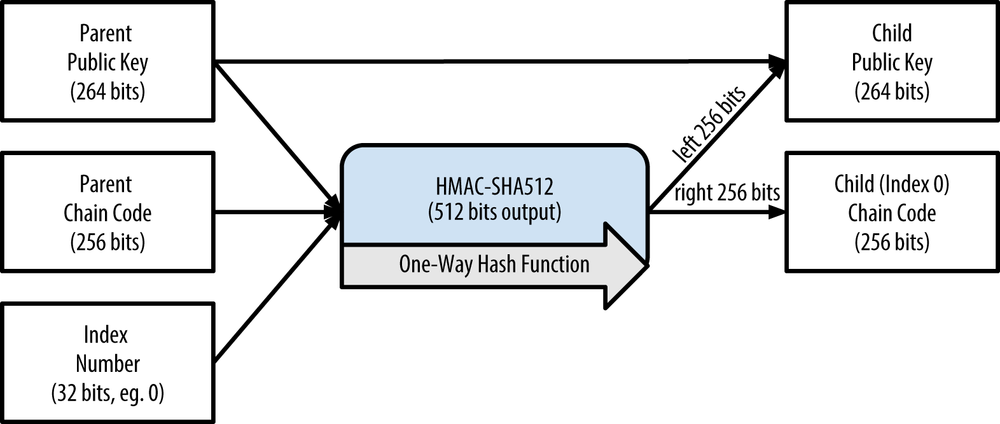

以下演示通过父扩展公钥导出子公钥和对应地址(无私钥参与)：

In [10]:
ext_pub_key_0_0 = []
pub_key_0_0 = []
address_0_0 = []
print("扩展公钥为:",ext_pub_key_0)
for i in range(0,10):
    ext_pub_key_0_0.append(bip32.ckd(ext_pub_key_0, i))
    temp_pub_key = bip32.base58.decode_check(ext_pub_key_0_0[i]).hex()
    pub_key_0_0.append(temp_pub_key[90:156])
    address_0_0.append(bip32.p2pkh_address_from_xpub(ext_pub_key_0_0[i]))
    print("第",i,"个派生:",pub_key_0_0[i],address_0_0[i])


扩展公钥为: b'xpub69jgwzpxwz6KrgQBbdbscM3LsH5sGiHp3kLidhXP1ooMdN8c9t4pBCs4VFEfTmvWzSxMCuKqQAakM2xp4R82ctvPTuu1a9peNc7fCBRhPzu'
第 0 个派生: 03bd13fa938fffe53add556f8ce822cb7e4852ff1d19d025f6a82d5f1bb3f12e28 b'12eSNwZy2BmKEML65ayA59reJrme4venzz'
第 1 个派生: 0300c3707696ab468b3d0e3966382bd539cc3c6ea0d921390bb242735028229143 b'1MPUx4YMGGkoxLHimh2BT1KJPbAQZFYgVw'
第 2 个派生: 0263d9f226387bb5f83cc7c877f78be8d18ad0a4e05fc8770387a5fd891b5262e3 b'16jpfMEMZbLWRfuDvzQk5ELRb1qTmfTvnU'
第 3 个派生: 02cb92206237d0476de2f41c0b217b9664034d5a61214a37badea8dc3b7609599e b'12kux6vgKPGZk4oA8wrF35rPtgzeuVuv9i'
第 4 个派生: 02c2372ade0552232873f02965c40195f6d8a188a4621a37fc14f564757c88eb0a b'16CPwFut9r4FzJSvt8MzXaC2rvZ1T8wcM5'
第 5 个派生: 03e81fe887cca4d4eb827014b395b6d02b3d204a44bc2aecc371d8f6c51b66d443 b'192HRnrVxadfR4M4NrTGGspbctyeEAVMhp'
第 6 个派生: 033ed7e5a3a90a4a5ff8cfc9bef40c61cdfaedf86f80ff7d053d12ec67a1e4c1ab b'1Muz6g8ZXnXpZACHG64Le7tvApHsFoMoHD'
第 7 个派生: 0258d40bdfb5363fbe2a2d935f2d1a58839207f50c3022f3d52ce913f996e3673b b'18

#### 强化子密钥派生
从扩展公钥派生子公钥分支的功能非常有用，但存在潜在的风险。拥有扩展公钥并不能拥有子私钥。但是，由于扩展公钥包含链码，因此，如果子私钥是已知的或以某种方式被泄漏，则可以将其与链码一起使用以导出所有其他子私钥。单个泄露的子私钥以及父链码将能推导出所有子级的所有私钥。更糟的是，子私钥与父链码一起可用于推导父私钥。

为了应对这种风险，HD钱包使用了另一种派生功能，即强化派生功能，该功能“打破”了父公钥和子链代码之间的关系。强化派生功能使用父私钥而不是父公钥来派生子链代码。这将在父/子序列中创建一个“防火墙”，其链码无法用于泄露父或同级私钥。强化派生函数看起来与普通的子私钥派生几乎相同，除了父私钥用作哈希函数的输入而不是父公钥。如下图所示：

当使用强化的私钥派生函数时，所得的子私钥和链码与正常派生函数所产生的完全不同。 由此产生的密钥“分支”可用于生成不易受到攻击的扩展公钥，因为它们所包含的链码不能被利用来揭示任何私钥。 因此，在使用扩展公钥中，使用了强化派生来创建“间隙”。

简而言之，如果您想利用扩展公钥的便利性来派生子公钥，而又不想使自己暴露于链码泄漏的风险中，则应该从强化的父级而不是普通的父级中派生它。 **作为最佳实践，主密钥的1级子代始终通过强化派生，以防止泄露主密钥。**
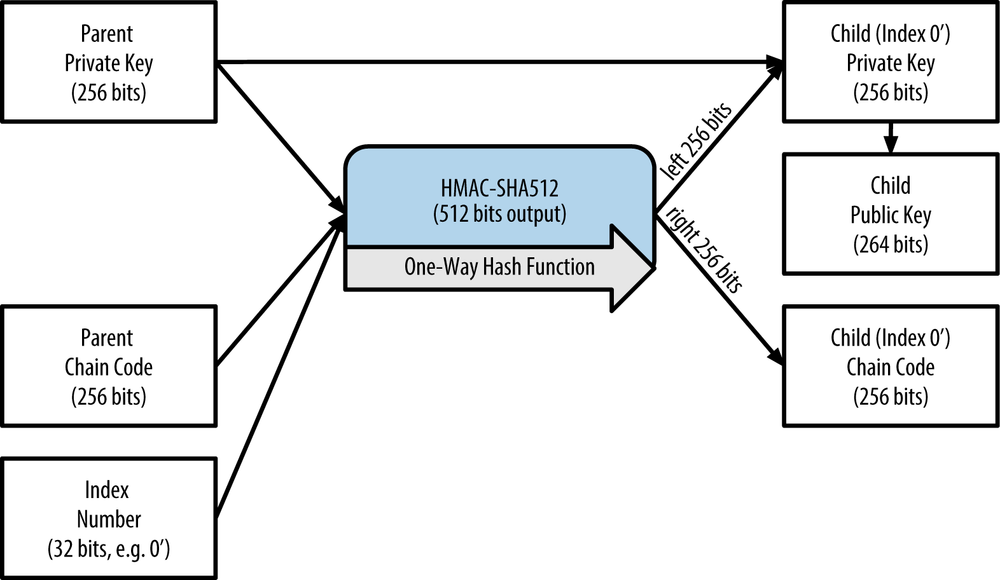

#### 正常和强化派生的索引号
> 衍生推导的方案其实有两个：一个用父私钥推导（称为强化衍生方程），一个用父公钥推导。同时为了区分这两种不同的衍生，在索引号也进行了区分，索引号小于2^31用于常规衍生，而2^31到2^32-1之间用于强化衍生，为了方便表示索引号i’，表示2^31+i。

推导函数中使用的索引号是32位整数。为了轻松地区分通过正常派生函数派生的密钥和通过强化派生函数派生的密钥，此索引号分为两个范围。 $$0到2^{31}–1$$之间的索引号（0x0到0x7FFFFFFF）仅用于正常派生。索引号介于$$2^{31}到2^{32}–1$$之间（0x80000000到0xFFFFFFFF）仅用于强化派生。因此，如果索引号小于2^31，则表示正常派生；而如果索引号等于或大于2^31，则表示强化派生。

为了使索引号更易于阅读和显示，已强化的索引号从零开始显示，但带有撇号。因此，第一个普通子项显示为0，而第一个强化子项（索引为0x80000000）显示为0'。然后按顺序，第二个强化密钥的索引为0x80000001，并显示为1'，依此类推。当您看到HD钱包索引i'时，表示2^31 + i。

### HD钱包密钥标识符（路径）
HD钱包中的密钥是使用“路径”命名约定来标识的，树的每个级别均由斜杠（/）字符分隔（如：`m/0/0`、`m/0'/0`、`M/23/17/0/0`）。 从主私钥派生的私钥以“m”开头。 从主公钥派生的公钥以“M”开头。 因此，主私钥的第一个子私钥为`m/0`。 第一个子公钥为`M/0`。 第一个孩子的第二个孙子是`m/0/1`，依此类推。

从右到左读取密钥的“祖先”，直到到达派生密钥的主密钥为止。 例如，标识符`m/x/y/z`描述的密钥是密钥`m/x/y`的第z个子代，这是密钥`m/x`的第y个子代，而密钥`m/x`是主密钥的第x个子代。

以下是不同路径下的密钥举例：

In [11]:
master_pub_key = bip32.xpub_from_xprv(master_key)
print("主密钥:",master_key)
print("\n扩展密钥(路径m/0/0):",bip32.derive(master_key, "m/0/0"))
print("\n扩展密钥(路径m/0'/0):",bip32.derive(master_key, "m/0'/0"))
# print("路径M/23/17/0/0:",bip32.derive(master_pub_key, "M/23/17/0/0"))

主密钥: xprv9s21ZrQH143K3DWGh7WmNUs1Q9VFJEk3bDXzUU8RDyGDDbYBhSuVXpqV2AAajvVQwhg61RUQbZvANXgmYYLfusQXLJHfZuD6s8ybyYMAu8J

扩展密钥(路径m/0/0): b'xprv9xATDHy29trRoTcqjyEcWzH6ecaWG56urmqMx53TwGDD225QszM2PGSU8zumRSRd83XMDQqQXM4SRy6zjtUVVyGMk488fB27JJ5az8d8YHA'

扩展密钥(路径m/0'/0): b'xprv9wywGXdhwJYPu5zPzqwuHePYmB86mYmhUErvGRTAhgzKZAhCs2SnN9z3PvZr9R8ZEVBe5xYf2uFtKzUGKR6Xh98RyRsi8oWSjMfzp2yKmVb'


### 如何导航HD钱包树结构
HD钱包树结构提供了极大的灵活性。每个父扩展密钥可以拥有40亿个子密钥：20亿正常派生子密钥和20亿强化派生子密钥。这些子密钥中的每个子密钥又可以再派生40亿个子密钥，依此类推。这棵树可以无限深。正由于具有这样的灵活性，导航这棵无限树变得非常困难。在实现HD钱包的转移功能将会变得特别困难，因为可能性实在是太多了。

通过为HD钱包树的结构创建一些提议的标准，两个比特币改进提案为这种复杂性提供了解决方案。 BIP0043建议使用第一个强化的子索引作为特殊标识符，以表示树结构的“用途”。基于BIP0043，HD钱包应仅使用树的一个1级分支，并且索引号通过定义树的用途来标识树的其余部分的结构和名称空间。例如，仅使用分支`m/i'`的HD钱包旨在表示特定目的，并且该目的由索引号“i”标识。

为了扩展该规范，BIP0044提出了一个多帐户结构，作为BIP0043下的“目的”编号44'。遵循BIP0044结构的所有HD钱包的标识是，它们仅使用树的一个分支：`m/44'`。

BIP44 是在 BIP32 和 BIP43 的基础上增加多币种，提出的层次结构非常全面，它允许处理多个币种，多个帐户，每个帐户有数百万个地址。
在BIP32路径中定义以下5个级别：
`m/purpse'/coin_type'/account'/change/address_index`

- purpose：在BIP43之后建议将常数设置为44'。表示根据BIP44规范使用该节点的子树。
- Coin_type：币种，代表一个主节点（种子）可用于无限数量的独立加密币，如比特币，Litecoin或Namecoin。此级别为每个加密币创建一个单独的子树，避免重用已经在其它链上存在的地址。开发人员可以为他们的项目注册未使用的号码。例如：比特币为`m/44'/0'`，比特币测试网为`m/44'/1'`，Litecoin是`m/44'/2'`。币种列表参考：https://github.com/satoshilabs/slips/blob/master/slip-0044.md
- Account：账户，此级别为了设置独立的用户身份可以将所有币种放在一个的帐户中，从0开始按顺序递增。它允许用户出于会计或组织目的将其钱包细分为单独的逻辑子帐户。
- Change：HD钱包具有两个子树，一个用于创建接收地址，另一个用于创建找零地址。请注意，尽管之前的层级使用强化派生，但此级别使用正常派生。这是为了允许树的该级别导出扩展公钥以在不安全的环境中使用。常量0用于外部接受地址，常量1用于内部找零地址。
- Address_index：地址索引，按顺序递增的方式从索引0开始编号。

以下演示作为Bitcoin和Ethereum的最佳HD钱包树实践：

In [12]:
standard_bitcoin_ext_pri_key = bip32.derive(master_key,"m/44'/0'/0'/0")
standard_bitcoin_ext_pri_key_0 = bip32.ckd(standard_bitcoin_ext_pri_key,0)
standard_bitcoin_ext_pri_key_0_hex = bip32.base58.decode_check(standard_bitcoin_ext_pri_key_0).hex()
standard_bitcoin_pri_key_0 = standard_bitcoin_ext_pri_key_0_hex[92:156]

standard_eth_ext_pri_key = bip32.derive(master_key,"m/44'/60'/0'/0")
standard_eth_ext_pri_key_0 = bip32.ckd(standard_eth_ext_pri_key,0)
standard_eth_ext_pri_key_0_hex = bip32.base58.decode_check(standard_eth_ext_pri_key_0).hex()
standard_eth_pri_key_0 = standard_eth_ext_pri_key_0_hex[92:156]


print("标准Bitcoin树 - 扩展私钥(m/44'/0'/0'/0):\n",standard_bitcoin_ext_pri_key)
print("派生的第0个私钥(Hex):",standard_bitcoin_pri_key_0)
print("派生的第0个私钥(WIF-C):",bip32.base58.encode_check(codecs.decode("80" + standard_bitcoin_pri_key_0 + "01",'hex')))
print("派生的第0个公钥:",ECC_compressed(standard_bitcoin_pri_key_0))
print("派生的第0个地址:",get_address(ECC_compressed(standard_bitcoin_pri_key_0)))

print("\n标准Ethereum树 - 扩展私钥(m/44'/60'/0'/0):\n",standard_eth_ext_pri_key)
print("派生的第0个私钥(Hex):",standard_eth_pri_key_0)
print("派生的第0个公钥:",ECC_compressed(standard_eth_pri_key_0))

标准Bitcoin树 - 扩展私钥(m/44'/0'/0'/0):
 b'xprvA1SJX9ssEbggYwzbQhUZ76AL8KKZBtb4n4wxPQByLbXCsurSUTkXXL4Gwf5ApuzQkHHsMAWNF84GSsqCrCQCrwEWRSt52f9pz2kSDFb4AwQ'
派生的第0个私钥(Hex): 12fe525adb010e90fe1006cf2c0f544f54ea0abb7af0e1aeab5ffd13050f47bb
派生的第0个私钥(WIF-C): b'Kwrdb95AEabnRQgKdFTWm5q4qTGVRVG4WzfrAo9nqwdYbK6DjiYD'
派生的第0个公钥: 031c9924d77e6f23104d140ff4eb25b028c7c79bf2e0a81295326faba5d2af4901
派生的第0个地址: b'1KMCQTUHuXQwDGP2nUUYon79dtqTLeDHpq'

标准Ethereum树 - 扩展私钥(m/44'/60'/0'/0):
 b'xprvA15U7bHMqX6A6QWAaZF8qQiJ6KvbwUFECbBzrsdEw3aqAoLStdnvZ9RBjfoK1T7fwYwSFzaChGXnNmu5MXRPiYXMoaVKHt389a37ZvdBByj'
派生的第0个私钥(Hex): a905f39ae0c4d930630faf5e9afbc595bd920df73b478c7434b4687a1a4922e9
派生的第0个公钥: 02d00476151e9d35872b754a08a114f5a650eeb1b83ea6914ca97bbcec8c8ecaae


---
以上是所有的原理
以下一气呵成演示下如何通过助记词生成钱包各级的私钥/地址的

---

In [8]:
import hashlib
import codecs
from mnemonic import Mnemonic
from btclib import bip32, bip39
from eth_keys import keys
# from binascii import hexlify, unhexlify
# from sha3 import keccak_256

def get_eth_address(public_key):
    addr = hashlib.sha3_256(public_key).digest()[-20:]
#     addr = keccak_256(public_key).digest()[-20:]
#     pkbin = unhexlify(public_key)
#     addressbin = ripemd160(hexlify(hashlib.sha256(pkbin).digest())).hex()
#     addressbin = hexlify(addressbin).decode('ascii')
#     addressbin = codecs.decode(address_version_prefix+addressbin,'hex')
#     address = base58.b58encode_check(addressbin)
    return addr

def str_to_hex(hex_string):
    an_integer = int(hex_string, 16)
    hex_value = hex(an_integer)
    return (hex_value)


In [16]:
mnemo_english = Mnemonic("english")

new_mnemonic = "recipe debris assault exit neck critic erosion exit asset breeze setup tongue"
new_seed_pwd = "123"
new_seed_npp12 = mnemo_english.to_seed(new_mnemonic,new_seed_pwd)
print("通过密码:{0},生成的种子:{1}".format(new_seed_pwd, new_seed_npp12.hex()))

new_master_key = mnemo_english.to_hd_master_key(new_seed_npp12)
print("获得分层确定性钱包主密钥：",new_master_key)

for i in range(0,1):
    path = f"m/44'/60'/0'/0"
    ext_pri_key_0 = bip32.derive(new_master_key, path)
    standard_ext_pri_key_0 = bip32.ckd(ext_pri_key_0,i)
    standard_eth_ext_pri_key_0_hex = bip32.base58.decode_check(standard_ext_pri_key_0).hex()
    pri_key = standard_eth_ext_pri_key_0_hex[92:156]
    print(pri_key)
#     pri_key = bytes(pri_key, 'hex')
#     pub_key = ECC_compressed(pri_key)
#     pub_key = keys.PublicKey.from_private(pri_key)
    
#     print(pub_key, pub_key_0)
#     pub_key = str_to_hex('0x'+pub_key)
#     print(type(pub_key), pub_key)
#     pub_address = get_eth_address(pub_key)
#     print("路径:{0}/{1}".format(path, i))
#     print("私钥:", pri_key)
#     print("公钥:", pub_key)
#     print("地址:", pub_address)
#     print(ext_pri_key_0)
#     print(standard_ext_pri_key_0)
#     print(path, standard_eth_pri_key_0)
# ext_pub_key_0 = bip32.xpub_from_xprv(ext_pri_key_0)
# standard_ext_pri_key_0 = bip32.ckd(ext_pri_key_0,0)
# standard_bitcoin_ext_pri_key_0 = bip32.ckd(standard_bitcoin_ext_pri_key,0)
# print("私钥：", standard_ext_pri_key_0)
# print("公钥：", ext_pub_key_0)

通过密码:123,生成的种子:970088068b7ec122cd0a8227956b873935fbe844a22ec623ec0f8b45265275bd717b90d59d0457f20f070ca155011d7ec2467db2f9b8a680eb3f565bd00e9a8e
获得分层确定性钱包主密钥： xprv9s21ZrQH143K4LMyG6XXohY4FChSdouovsZmreRW74jfAy94hWsBtNUVd48GYh9U75EqcCh498ky4ybw4yhnCvpqcefoBDYP6xnLXffvb9i
929316cd7e3ab58cfdfe4ef9d0a3f8adbd1454ff32817396a8690c8206c69eed
